[Source at Rosetta Code](https://rosettacode.org/wiki/A*_search_algorithm#Python)

In [248]:
import matplotlib.pyplot as plt
import numpy as np
from bisect import bisect
import pandas as pd

class sailboat(object):
    """Class containing performance data for boat
    
    polars ==> table of nth degree polynomials for wind vs speed
    minWindAngle ==> minimum sailing angle in degrees
        VTW:  True Wind Speed (knots, at a height of 10 meters above water)
        BTW:  True Wind Angle (degrees away from dead upwind)
        VAW:  Apparent Wind Speed (knots)
        BAW:  Apparent Wind Angle (degrees away from bow of boat)
        V:    Boat Speed (knots)
        VMG:  Velocity Made Good (knots, component of V that is directly up or down wind)
        PHI:  Heel Angle (degrees from upright)
        REEF: Indicator of sail area reduction for optimal performance (1: full sail area)
        FLAT: Indicator of de-powering of sails for optimal performance (1: fully powered up)
        Headsail: Indicator of headsail
        Notes: Notes for configuration"""
    
    def __init__(self,polarsModel=None,polarsTableFile=None,polarsTableData=None, \
                 minWindAngle=-99,lengthOverAll=50,wave_hindrance_model=None,\
                 hullname="SV Boaty Mcboatface",H_average_speed=6):
        self.polars        = polarsModel
        self.clamp_RWA     = minWindAngle*np.pi/180
        self.polars_speeds = sorted(polarsModel.keys())
        self.polars_guts   = np.matrix([ polarsModel[cha] for cha in self.polars_speeds])
        self.LOA           = lengthOverAll
        self.WHM           = wave_hindrance_model
        self.hullname      = hullname
        self.heuristic_average_speed=H_average_speed  #knots ==> speed used for cost estimates for unfinished
                                                      # part of the journey to the goal.
        if not polarsTableFile is None:
            self.polarsTable = pd.read_csv(polarsTableFile,sep=',')
        if not polarsTableData is None:
            self.polarsTable =pd.DataFrame(polarsTableData[1:],columns=polarsTableData[0])
            print(df1)
        cnt=0
        if self.polarsTable is None:
            self.pivotTable = {}
        else:
            self.pivotTables={parm: pd.pivot_table(SVSunflower.polarsTable[(SVSunflower.polarsTable.Notes!='OPTUP' ) &\
                                                                           (SVSunflower.polarsTable.Notes!='OPTDN') ], \
                                                   values=parm, index=['BTW'],columns=['VTW'], aggfunc=np.mean) for parm \
                              in ['V','REEF','PHI','FLAT'] }
            self.pivotTables['Headsail']=pd.DataFrame(index=self.pivotTables['V'].index,\
                                                      columns=self.pivotTables['V'].columns,dtype='str')
            self.BTWbisector=lambda x : bisect([0.]+sorted(self.pivotTables['V'].index)+[181.], x)
            self.VTWbisector=lambda x : bisect([0.]+[float(ii) for ii in sorted(self.pivotTables['V'].columns)]+[150.], x)
            self.BTWVTWsize=(len(self.pivotTables['V'].index),len(self.pivotTables['V'].columns))
            criterion = self.polarsTable['Notes'].map(lambda x:  (isinstance(x, basestring) and not "OPT" in x) or \
                                                 not isinstance(x, basestring))
            for VVTW in self.pivotTables['V'].columns:
                    self.pivotTables['Headsail'][VVTW]=self.polarsTable.Headsail[ criterion &  (self.polarsTable.VTW==VVTW) ].tolist()
              
            
        
    def speed_from_polars(self,RWA,TWS=6):
        """Returns boat speed from relative wind angle and speed"""
        if self.clamp_RWA>0 and RWA<self.clamp_RWA:
            result=-99
        else:
            order=self.polars_guts.shape[1]
            y=np.ones(order)
            for i in range(order-1,0,-1):
                y[i-1]=y[i]*RWA
            result_vec=(self.polars_guts*np.matrix(y).transpose()).transpose().tolist()
            result=np.interp(TWS,[0.] + self.polars_speeds + [self.polars_speeds[-1]*3], \
                             [0.] + result_vec[0] + [result_vec[0][-1]],left=-99,right=-99)
        if result > 0:
            return result
        else:
            return 0.001  
        
    def plot_polars(self):
        """Make a plot of boat's Polars"""
        ##
        ## Make a plot of our Polars
        ## 
        ## keep this
        ##
        plt.figure(figsize=(12,7))
        plt.title(self.hullname+": Boat Speed (model) vs True Wind Angle vs True Wind Speed")
        RWA = np.arange(0,np.pi,0.1)
        #[(ii*180/np.pi,PS.speed_from_polars(ii,1.)) for ii in RWA]
        for TWS in self.polars_speeds:
            plt.plot([ii*180/np.pi for ii in RWA],[self.speed_from_polars(ii,TWS) for ii in RWA], '-o',label="TWS = %d"%TWS)
        plt.plot([1.,175.],[self.heuristic_average_speed]*2,'-.',label="Heuristic Ave Spd",color='grey')
        plt.legend()       
        plt.xlabel("true wind angle (degrees)")
        plt.ylabel("boat speed(knots)")

        
    def plot_Tables(self,parm):
        plt.figure(figsize=(12,7))
        plt.title(self.hullname+": "+ parm + " vs True Wind Angle vs True Wind Speed")
        tableToPlot=self.pivotTables[parm]
        #RWA = np.arange(0,np.pi,0.1)
        #[(ii*180/np.pi,PS.speed_from_polars(ii,1.)) for ii in RWA]
        if parm=='Headsail':
            bla=[]
            allVals=[bla.extend(Cha[xx].unique()) for xx in Cha.columns]
            allVals=list(set(bla))
            del bla
            ##do this instead: https://gist.github.com/amanahuja/0c2b6f086eed9d6c2fe0
            for TWS in tableToPlot.columns:
                plt.plot(tableToPlot[TWS].index,[ 1+ TWS/100. +allVals.index(ii) for ii in tableToPlot[TWS].values], '-o',label="TWS = %d"%TWS)
            plt.ylim([0,len(allVals)+2])
            for i,labb in enumerate(allVals):
                plt.text(10.,i+1,labb)
            plt.ylabel([])
        else:
            for TWS in tableToPlot.columns:
                plt.plot(tableToPlot[TWS], '-o',label="TWS = %d"%TWS)
        plt.legend()       
        plt.xlabel("true wind angle (degrees)")
        plt.ylabel(parm)
        plt.xlim([0,180])
        
    def LookupValues(self,VTW,BTW,parms=['V']):
        lowBTW,lowVTW=(self.BTWbisector(BTW),self.BTWbisector(VTW))
        if lowBWT==self.BTWVTWsize[0]:
            highBTW=self.BTWVTWsize[0]
        else:
            highBTW=self.BTWVTWsize[0]+1
        if lowVWT==self.BTWVTWsize[1]:
            highVTW=self.BTWVTWsize[1]
        else:
            highVTW=self.BTWVTWsize[1]+1

        return False


                
        
    def wave_drag(self,wavePeriod=1000,waveAOB=0):
        """TODO - write wave drag model"""
        return 0

SVSunflr={ 6:[0.315679931593773,-5.11963598638016,34.2073561957758,-121.695198238111,248.489879048305, \
                -290.644183172735,176.372420712742,-34.0123838853998,-2.16034293014928],
8:[0.0238604376817297,-0.567721437819886,4.07062500047844,-11.2940636816077,4.11965019586976,43.6666758062587, \
   -99.7920563994945,92.466538852542,-25.6480289006842],
10:[-0.0591241174313379,0.380032419176075,0.342894143767638,-7.55209469474344,17.5946838478113, \
    -1.24634408220442,-46.3390695103949,63.9918649480057,-19.1632945804615],
12:[-0.481916973640513,	7.60260153773329,-51.7505967950519,199.202079989257,-475.182437672317, \
    719.164802893553,-675.017774649225,361.932657214902,-77.0202204468818],
16:[0.0887857639696129,	-0.766710112052253,	-0.334816588305918,	27.3135355851111,	-135.151085559757, \
    313.676735642741,	-390.433451995094,	253.203172667432,	-58.6155260162626],
20:[-0.00579737621930548,	-0.0338403103021861,	-0.347056346202211,	10.3569732499987,	-62.9019494841648, \
    173.144263412207,	-245.571117560733,	176.57312725869,	-42.0001355117172],
24:[-1.63924336010598,	24.5126163155162,	-156.711881615492,	560.967952674478,	-1234.15058604918, \
    1714.29897021706,	-1471.25577756942,	715.945845392126,	-142.696823393666]}

SVSunflower=sailboat(SVSunflr,minWindAngle=40.,hullname="SV Sunflower",polarsTableFile="SUNFLOWERmod.csv")

%matplotlib inline
if False:
    SVSunflower.plot_polars()
    for pltParm in ['V','REEF','PHI','FLAT','Headsail']:
        SVSunflower.plot_Tables(pltParm)
#SVSunflower.plot_Tables('Headsail')

    


In [254]:
print SVSunflower.pivotTables['V'].index,len(SVSunflower.pivotTables['V'].index)
print SVSunflower.pivotTables['V'].columns,len(SVSunflower.pivotTables['V'].columns)

print SVSunflower.BTWbisector(45.5)
cha=[0]+sorted(SVSunflower.pivotTables['V'].columns)+[100]
chb=[0]+sorted(SVSunflower.pivotTables['V'].index)+[200]
for i in np.linspace(0.,32.,32):
    print  cha[SVSunflower.VTWbisector(i)-1], i,\
    cha[SVSunflower.VTWbisector(i)],"                ",chb[SVSunflower.BTWbisector(i*6)-1], i*6,\
    chb[SVSunflower.BTWbisector(i*6)]

 Float64Index([ 40.0,  45.0,  50.0,  55.0,  60.0,  65.0,  70.0,  75.0,  80.0,
               85.0,  90.0,  95.0, 100.0, 105.0, 110.0, 115.0, 120.0, 125.0,
              130.0, 135.0, 140.0, 145.0, 150.0, 155.0, 160.0, 165.0, 170.0,
              175.0, 180.0],
             dtype='float64', name=u'BTW') 29
Int64Index([6, 8, 10, 12, 16, 20, 24], dtype='int64', name=u'VTW') 7
3
0 0.0 6                  0 0.0 40.0
0 1.032258064516129 6                  0 6.193548387096774 40.0
0 2.064516129032258 6                  0 12.387096774193548 40.0
0 3.096774193548387 6                  0 18.58064516129032 40.0
0 4.129032258064516 6                  0 24.774193548387096 40.0
0 5.161290322580645 6                  0 30.967741935483872 40.0
6 6.193548387096774 8                  0 37.16129032258064 40.0
6 7.225806451612903 8                  40.0 43.354838709677416 45.0
8 8.258064516129032 10                  45.0 49.54838709677419 50.0
8 9.29032258064516 10                  55.0 55.74193548387096 6

IndexError: list index out of range

In [227]:
import bisect
def grade(score, breakpoints=[60, 70, 80, 90], grades='FDCBA'):
    i = bisect.bisect(breakpoints, score)
    return grades[i]

[grade(score) for score in [33, 99, 77, 70, 89, 90, 100]]


['F', 'A', 'C', 'C', 'B', 'A', 'A']

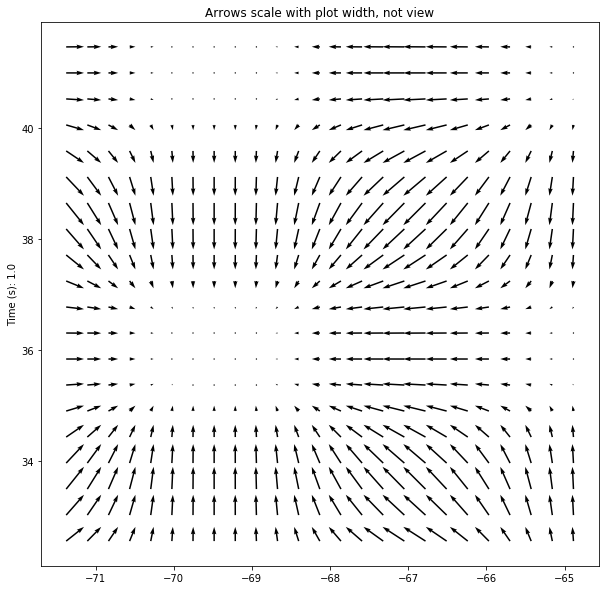

RuntimeError: Error creating movie, return code: 1 Try setting mpl.verbose.set_level("helpful")

In [12]:
import numpy as np

class timeVectorMap(object):
    """Class containing a time-varying meshgrid of U,V vectors as well as their X,Y locations"""
    class HelperFunctions(object):
        def LineTwo(self,A,B,width=(1,1),skiplast=False,Integer=False,UVFunc=lambda x,y,sT,cT : None):
            """Returns a Line between A & B with width varying from width[0] to width[1]

                TODO: Make this suck less in "Integer mode" - it's just aweful
                
                Integer ==> Returned X,Y points are integers
            """
            (x0,y0)=A
            (x1,y1)=B
            result=[]
            dx = x1 - x0
            dy = y1 - y0
            #delta=0 if width%2==0 else 1
            sqdxdy=(dx**2+dy**2)**0.5 
            #print "line length:",sqdxdy,"dx,dy:",(dx,dy)
            Xs=range(int(sqdxdy+0.5))
            if skiplast:
                Xs.pop()
            Widths=np.int32(0.5+np.linspace(width[0],width[1],len(Xs)))
            if sqdxdy>1:
                for x,thiswidth in zip(Xs,Widths):
                    for y in range(thiswidth/2,-thiswidth/2,-1):
                        result.append((x,y,None))
            sinT=dy/sqdxdy
            cosT=dx/sqdxdy
            result=[(x*cosT-y*sinT+x0,x*sinT+y*cosT+y0,UVFunc(x,y,sinT,cosT)) for x,y,w in result]
            if Integer:
                result=[(int(x+ (0.5 if x>0 else -0.5)),int(y+ (0.5 if y>0 else -0.5)),w) for x,y,w in result]
                #dedup results
                # TODO
            return result

        def Ring(self,C,R,spans=6,width=1,Integer=False,UVFunc=lambda x,y,sT,cT : None):
            """Returns a Ring centered at C of radius R with width=width made from span chords

                Integer ==> X,Y points are integers
            """
            cSteps=np.linspace(0.,2.*np.pi,spans+1)
            result=[]
            Cx,Cy=C
            for ii in cSteps[0:-1]:
                A=(Cx+R*np.cos(ii),Cy+R*np.sin(ii))
                B=(Cx+R*np.cos(ii+2.*np.pi/(spans+1)),Cy+R*np.sin(ii+2.*np.pi/(spans+1)))
                result.extend(self.LineTwo(A,B,(width,width),Integer=Integer,UVFunc=UVFunc))
            return result
        
    def __init__(self,w,h,TopLeft,BottomRight,allTimes):
        """returns an table of vectors in knots vs time"""
        self.w=w
        self.h=h
        self.TopLeft=TopLeft
        self.BottomRight=BottomRight
        self.allTimes=allTimes
        self.U,self.V,self.T=np.meshgrid(np.linspace(0.,1.,w) ,np.linspace(0.,1.,h),allTimes)
        self.Y,self.X=np.meshgrid(np.linspace(TopLeft[0], BottomRight[0],w) , \
                                  np.linspace(TopLeft[1], BottomRight[1],h))

    def get_LocationParameters(self,node=None,LoLa=None, gscore=0,degrees=False):

        #TODO ==> adjust wind speed based on gscore (time)
        #TODO ==> add Current lookup and speed
        if LoLa is None:
            (x1, y1) = node
            (La1,Lo1) = (self.Y[x1,y1],self.X[x1,y1])
        else:
            (Lo1,La1)=LoLa
            (x1,y1) = self.getXYfromLoLa(Lo1,La1)
        vecField=(self.U[x1,y1],self.V[x1,y1])
        TVS=math.hypot(vecField[0],vecField[1])
        #print "Wind:",wind, " TWA:",(np.arctan2(wind[0],wind[1])*180./np.pi+360)%360
        #print "boat_vector:", boat_vector, " Boat Course:",
        TVA=np.arctan2(vecField[0],vecField[1])
        if degrees:
            TVA=(TVA*180./np.pi+360)%360
        return TVS,TVA
    
           #     order=self.polars_guts.shape[1]
           # y=np.ones(order)
           # for i in range(order-1,0,-1):
           #     y[i-1]=y[i]*RWA
           # result_vec=(self.polars_guts*np.matrix(y).transpose()).transpose().tolist()
           # result=np.interp(TWS,[0.] + self.polars_speeds + [self.polars_speeds[-1]*3], \
           #                  [0.] + result_vec[0] + [result_vec[0][-1]],left=-99,right=-99)
            #if result > 0:
            #    return result
            #else:
            #    return 0.001  


    def makeFakeSinCosVectors(self,scales,windMult):
        """Create a time-varying field vectors based on sin/cos of location"""
        cnt=0
        for tim,scale in zip(self.T[0,0,:],scales):
            Uu = np.cos(self.X*scale[0]*tim*np.pi/180.)
            Vv = np.sin(self.Y*scale[1]*tim*np.pi/180.)
            Uu = Uu * abs(Uu)**2
            Vv = Vv * abs(Vv)**2
            Uu=Uu*windMult
            Vv=Vv*windMult
            self.U[...,cnt]=Uu
            self.V[...,cnt]=Vv
            cnt+=1
    
    def getXYfromLoLa(Lo,La):
        LoLo=[self.X[iii,0] for iii in [0,-1]]+[len(self.X[...,0])]
        LaLa=[self.Y[0,iii] for iii in [0,-1]]+[len(self.Y[0,...])]
        return (int(0.5+ LoLo[2]*(Lo-LoLo[0])/(LoLo[1]-LoLo[0])),int(0.5+ LaLa[2]*(La-LaLa[0])/(LaLa[1]-LaLa[0])))


from matplotlib.animation import FuncAnimation

#what is the size of it?
w,h=(40,50)
TopLeft=(41.4646,-71.3749)
BottomRight=(32.3191,-64.7526)
windMult=20.

Steps=80
MaxTime=1.5
ScaleGrowth=2.
allTimes=np.linspace(1.,MaxTime,Steps)
allScales=zip(np.linspace(35.,35.+ScaleGrowth,Steps),np.linspace(35.,35.+ScaleGrowth,Steps))
#print "AllScales:",allScales
#m=make_wind_map_mega(timescales=timescales)
m=timeVectorMap(w,h,TopLeft,BottomRight,allTimes)
m.makeFakeSinCosVectors(allScales,windMult=windMult)

arrowSpacing=2

fig, ax = plt.subplots(figsize=(10, 10))

#ax1=plt.subplot(211)
plt.title('Arrows scale with plot width, not view')
step=0
#cmap = plt.cm.jet
qax = ax.quiver(m.X[::arrowSpacing,::arrowSpacing], m.Y[::arrowSpacing,::arrowSpacing], \
               m.U[::arrowSpacing,::arrowSpacing,step], m.V[::arrowSpacing,::arrowSpacing,step] \
               ,units='width',scale=500)

def animate(i):
    qax.set_UVC(m.U[::arrowSpacing,::arrowSpacing,i], m.V[::arrowSpacing,::arrowSpacing,i])
    #qax.set_color(cmap(30+i*20))
    ax.set_ylabel('Time (s): ' + str(int(allTimes[i]*1000)/1000.))
    
anim = FuncAnimation(
    fig, animate, interval=150, frames=len(timescales)-1)
 
plt.draw()
plt.show()

anim.save('allwinds.mp4')
#plt.figure(figsize=(10,10))
#fig, ax = plt.subplots(figsize=(10, 10))

#def make_wind_map(w=30, h=30,TopLeft=(41.4646,-71.3749),BottomRight=(32.3191,-64.7526),scale=7.,windMult=1.):
#    def __init__(self, windmap, polars,clamp_RWA=-99,H_average_speed=6,neighbor_range=2):


In [21]:
(NEWm.U[5,5,:],NEWm.V[5,5,:])

(array([14.50949751,  1.79457068,  1.97131978]),
 array([ 1.81504461e-04, -3.16827229e+00, -1.99941189e+01]))

In [19]:
NEWm.allTimes

array([ 1. ,  5.5, 10. ])

In [26]:
print [m.X[iii,0] for iii in [0,-1]]
print [m.Y[0,iii] for iii in [0,-1]]
Lo,La=(-73.,35.)
LoLo=[m.X[iii,0] for iii in [0,-1]]+[len(m.X[...,0])]
LaLa=[m.Y[0,iii] for iii in [0,-1]]+[len(m.Y[0,...])]
X,Y=(int(0.5+ LoLo[2]*(Lo-LoLo[0])/(LoLo[1]-LoLo[0])),int(0.5+ LaLa[2]*(La-LaLa[0])/(LaLa[1]-LaLa[0])))
print X,Y, "==>", Lo,La
print [[(m.X[X+Xx,0],m.Y[0,Y + Yy]) for Xx in [-1,0,1]] for Yy in [-1,0,1]]


[-71.3749, -64.7526]
[41.4646, 32.3191]
-11 28 ==> -73.0 35.0
[[(-66.2392387755102, 35.1331), (-66.10408979591837, 35.1331), (-65.96894081632654, 35.1331)], [(-66.2392387755102, 34.8986), (-66.10408979591837, 34.8986), (-65.96894081632654, 34.8986)], [(-66.2392387755102, 34.6641), (-66.10408979591837, 34.6641), (-65.96894081632654, 34.6641)]]


REV 1 - Updated to use Boat Class


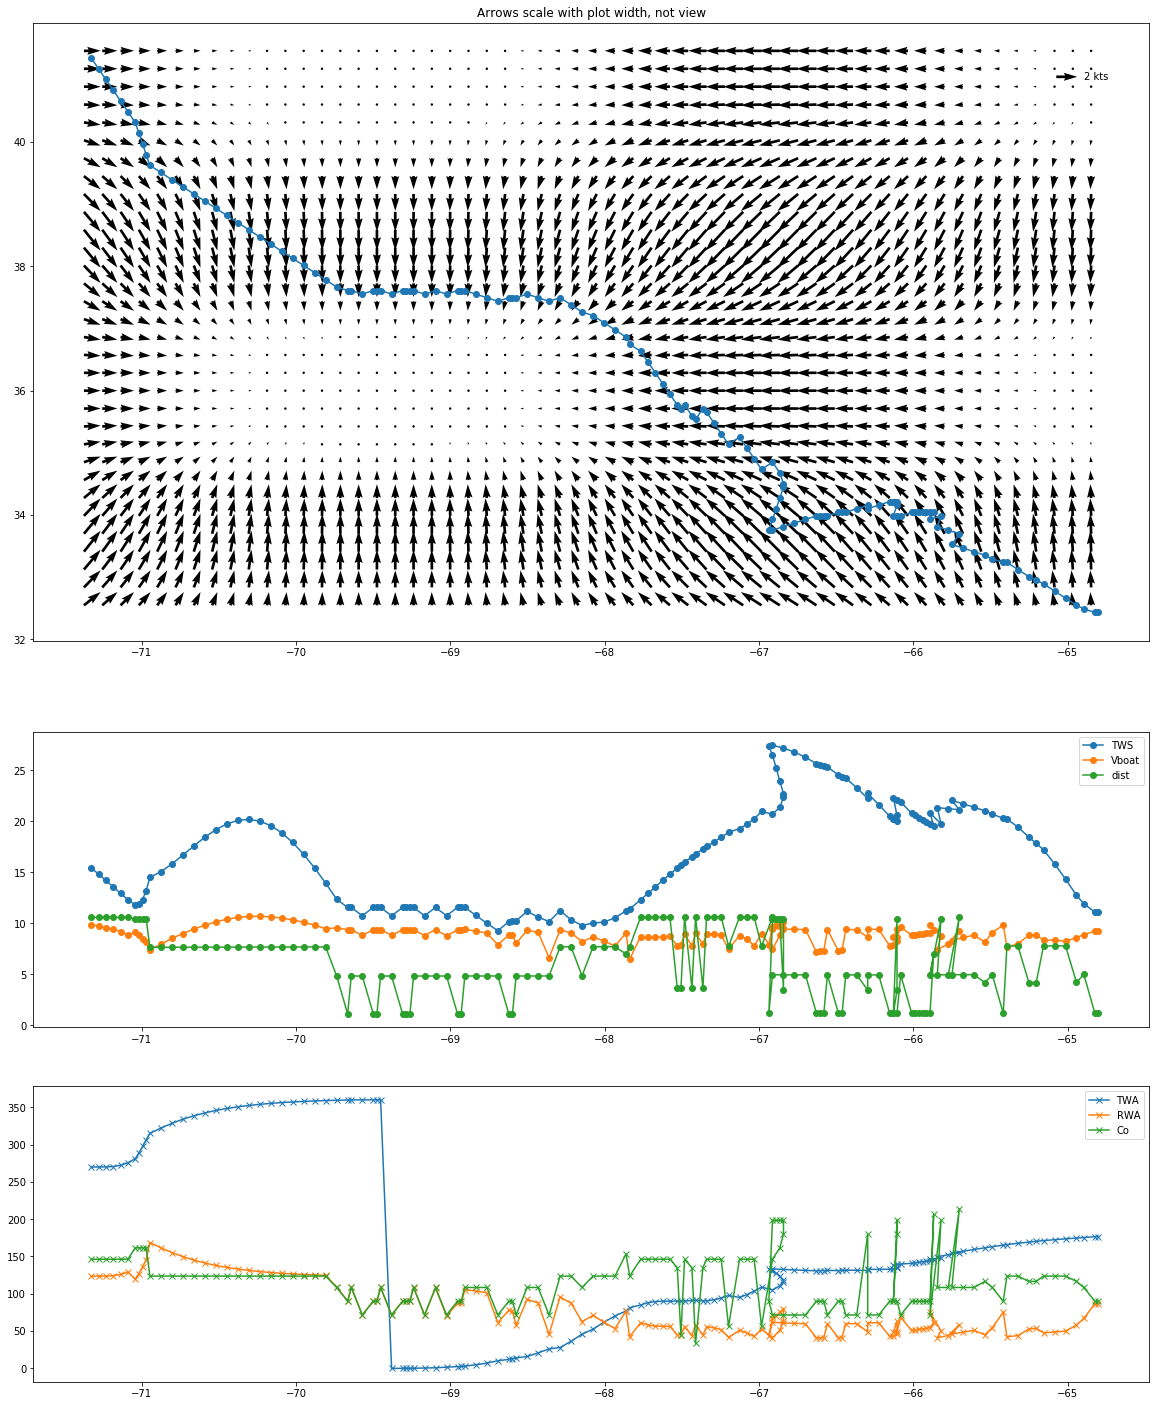

In [14]:
###REV 1
print "REV 1 - Updated to use Boat Class"

import matplotlib.pyplot as plt
import numpy as np
from numpy import ma
from myAstar import AStar
import sys
import math
%matplotlib inline



class PathSolver(AStar):
    """uses of the astar algorithm to navigate a boat between two locations through a Windmap.
    a 'node' is just a (x,y) tuple that represents a reachable position"""
    def __init__(self, windmap, boat,neighbor_range=2):
        self.boat = boat
        self.width = windmap['U'].shape[0]
        self.height = windmap['U'].shape[1]
        self.windmap = windmap
        #determins how far out a cell is considered a neighbor of a given cell.
        self.neigh=[(0,1),(0,-1),(-1,-1),(-1,0),(-1,1),(1,-1),(1,0),(1,1)]
        if neighbor_range>1:     #Default
            self.neigh.extend([(-2,1),(-2,-1),(-1,-2),(-1,2),(1,-2),(1,2),(2,-1),(2,1)])
        if neighbor_range>2:
            self.neigh.extend([(-3,2),(-3,1),(-3,-2),(-3,-1),(-2,-3),(-2,3),(-1,-3),(-1,3),(3,2),\
                               (3,1),(3,-2),(3,-1),(2,-3),(2,3),(1,-3),(1,3)])
        if neighbor_range>3:
            self.neigh.extend([(-4,-3),(-4,-2),(-4,-1),(-4,1),(-4,2),(-4,3),\
                               (4,-3),(4,-2),(4,-1),(4,1),(4,2),(4,3),\
                                (-3,-4),(-2,-4),(-1,-4),(1,-4),(2,-4),(3,-4),\
                               (-3,4),(-2,4),(-1,4),(1,4),(2,4),(3,4),])


    def plotPath(self, pathin, arrowSpacing=1):
        pathpoints=[(self.windmap['X'][pp[0],pp[1]],self.windmap['X'][pp[0],pp[1]],m['U'][pp[0],pp[1]],m['V'][pp[0],pp[1]]) for pp in pathin]
        plt.figure(figsize=(20,25))
        ax1=plt.subplot(211)
        
        plt.title('Arrows scale with plot width, not view')
        Q = plt.quiver(self.windmap['X'][::arrowSpacing,::arrowSpacing], self.windmap['Y'][::arrowSpacing,::arrowSpacing], \
                       self.windmap['U'][::arrowSpacing,::arrowSpacing], self.windmap['V'][::arrowSpacing,::arrowSpacing], units='width')
        qk = plt.quiverkey(Q, 0.85, 0.85, max(abs(self.windmap['U'].max()),abs(self.windmap['V'].max())), r'2 kts', labelpos='E', \
                           coordinates='figure')
        plt.plot([self.windmap['X'][pp[0],pp[1]] for pp in pathin],[self.windmap['Y'][pp[0],pp[1]] for pp in pathin],'-o')
        boatdata=[self.get_LocationParameters(pathin[ppi],pathin[ppi+1],degrees=True) for ppi in range(len(pathin)-1)]
        boatdata.append(boatdata[-1])
        ax2=plt.subplot(413,sharex=ax1)
        plt.plot([self.windmap['X'][pp[0],pp[1]] for pp in pathin],[ pp[1] for pp in boatdata],'-o',label='TWS')
        plt.plot([self.windmap['X'][pp[0],pp[1]] for pp in pathin],[ pp[5] for pp in boatdata],'-o',label='Vboat')
        plt.plot([self.windmap['X'][pp[0],pp[1]] for pp in pathin],[ pp[0] for pp in boatdata],'-o',label='dist')
        plt.legend()
        ax2=plt.subplot(414,sharex=ax1)
        plt.plot([self.windmap['X'][pp[0],pp[1]] for pp in pathin],[ pp[2] for pp in boatdata],'-x',label='TWA')
        plt.plot([self.windmap['X'][pp[0],pp[1]] for pp in pathin],[ pp[3] for pp in boatdata],'-x',label='RWA')
        plt.plot([self.windmap['X'][pp[0],pp[1]] for pp in pathin],[ pp[4] for pp in boatdata],'-x',label='Co')
        plt.legend()
        return boatdata
        
    def unit_vector(self,vector):
        """ Returns the unit vector of the vector.  """
        return vector / np.linalg.norm(vector)

    def angle_between(self,v1, v2):
        """ Returns the angle in radians between vectors 'v1' and 'v2'::

                >>> angle_between((1, 0, 0), (0, 1, 0))
                1.5707963267948966
                >>> angle_between((1, 0, 0), (1, 0, 0))
                0.0
                >>> angle_between((1, 0, 0), (-1, 0, 0))
                3.141592653589793
        """
        v1_u = self.unit_vector(v1)
        v2_u = self.unit_vector(v2)
        return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

    def get_LocationParameters(self,n1,n2, gscore=0,degrees=False):

        #TODO ==> adjust wind speed based on gscore (time)
        #TODO ==> add Current lookup and speed
        (x1, y1) = n1
        (x2, y2) = n2
        (La1,Lo1) = (self.windmap['Y'][x1,y1],self.windmap['X'][x1,y1])
        (La2,Lo2) = (self.windmap['Y'][x2,y2],self.windmap['X'][x2,y2])
        wind=(-self.windmap['U'][x1,y1],-self.windmap['V'][x1,y1])
        boat_vector=(x2-x1,y1-y2)
        meanLat=(La1+La2)/2.
        TWS=math.hypot(wind[0],wind[1])
        #distance in nm
        dist=math.hypot((Lo2 - Lo1)*np.cos(meanLat*np.pi/180.), La2 - La1)*60.
        #print "Wind:",wind, " TWA:",(np.arctan2(wind[0],wind[1])*180./np.pi+360)%360
        #print "boat_vector:", boat_vector, " Boat Course:",
        if degrees:
            TWA=(np.arctan2(wind[0],wind[1])*180./np.pi+360)%360
            course=(np.arctan2(boat_vector[0],boat_vector[1])*180./np.pi+360)%360
        else:
            TWA=np.arctan2(wind[0],wind[1])
            course=np.arctan2(boat_vector[0],boat_vector[1])
        #print "boat_vector:", boat_vector, " Boat Course:",
        RWA=self.angle_between(wind,boat_vector)
        #print "Relative True Wind Angle:",ang*180/np.pi
        BoatSpeed=self.boat.speed_from_polars(RWA,TWS)
        #print "Boat Speed: ", BoatSpeed
        if degrees:
            RWA=RWA*180/np.pi
        return dist,TWS,TWA,RWA,course,BoatSpeed
    
#### Below are the standard A-Star Functions
    def heuristic_cost_estimate(self, n1, n2, gscore=0):
        """computes the time to travel 'direct' distance between two (x,y) tuples"""
        #TODO ==> use smarter heuristic based on 
        (x1, y1) = n1
        (x2, y2) = n2
        (La1,Lo1) = (self.windmap['Y'][x1,y1],self.windmap['X'][x1,y1])
        (La2,Lo2) = (self.windmap['Y'][x2,y2],self.windmap['X'][x2,y2])
        meanLat=(La1+La2)/2.
        dist=math.hypot((Lo2 - Lo1)*np.cos(meanLat*np.pi/180.), La2 - La1)*60./self.boat.heuristic_average_speed
        return dist

    def distance_between(self, n1, n2, gscore=0):
        """this method returns the time to travel into a neighbor's cell based on conditions in the current cell"""
        # We're cheating a bit as some of the neighbors aren't exactly adjacent but we're 
        # assuming the prevailing local conditions are such that it doesn't matter 
        dist,TWS,TWA,RWA,course,BoatSpeed = self.get_LocationParameters(n1,n2,gscore)
        #cost is distance/speed
        return dist / BoatSpeed

    def neighbors(self, node):
        """ for a given coordinate in the maze, returns up to adjacent
            nodes that can be reached 
        """
        x, y = node
        return[(nx, ny) for nx, ny in [(x+xx,y+yy) for xx,yy in self.neigh] if 0 <= nx < self.width and \
               0 <= ny < self.height ]

size = 200
# what is the size of it?
w = 160
h = 280
m = make_wind_map(w,h,scale=35,windMult=20.)

Steps=3
MaxTime=10.
ScaleGrowth=5.
allTimes=np.linspace(1.,MaxTime,Steps)
allScales=zip(np.linspace(35.,35.+ScaleGrowth,Steps),np.linspace(35.,35.+ScaleGrowth,Steps))
#m=make_wind_map_mega(timescales=timescales)
NEWm=timeVectorMap(w,h,TopLeft,BottomRight,allTimes)
NEWm.makeFakeSinCosVectors(allScales,windMult=windMult)

m={'text':'','X':NEWm.X,'Y':NEWm.Y,'U':NEWm.U[...,0],'V':NEWm.V[...,0]}


# table of 8th order Polinomials representing boat speed vs TWA
# 1st term is X^8 last term is X^0
#

Lowest_RelativeWindAngle=38. 

PS=PathSolver(m,SVSunflower,neighbor_range=3)

start = (2, 2)  # we choose to start at the upper left corner
goal = (h - 3,w - 3)  # we want to reach the lower right corner

# let's solve it
foundPath = list(PS.astar(start, goal))
# print the solution
pPPS=PS.plotPath(foundPath,arrowSpacing=5)
#print pPPS

In [ ]:
vec

In [3]:
import numpy as np

def make_wind_map(w=30, h=30,TopLeft=(41.4646,-71.3749),BottomRight=(32.3191,-64.7526),scale=7.,windMult=1.):
    """returns an table of wind vectors in knots"""
    ##TODO - make 
    result = ('+' + '='*w + '+\n') + ('|' + ' '*w + '|\n')*h + ('+' + '='*w + '+')
    Y,X = np.meshgrid(np.linspace(TopLeft[0], BottomRight[0],w) , \
                      np.linspace(TopLeft[1], BottomRight[1],h))
    U = np.cos(X*scale*np.pi/180.)
    V = np.sin(Y*scale*np.pi/180.)
    U = U * abs(U)**2
    V = V * abs(V)**2
    U=U*windMult
    V=V*windMult
    return {'text':result.strip(),'X':X,'Y':Y,'U':U,'V':V}

class dummy(object):
    def makeFakeSinCosVectors(self,scales,windMult):
        """Create a time-varying field vectors based on sin/cos of location"""
        cnt=0
        for tim,scale in zip(self.T[0,0,:],scales):
            Uu = np.cos(self.X*scale[0]*tim*np.pi/180.)
            Vv = np.sin(self.Y*scale[1]*tim*np.pi/180.)
            Uu = Uu * abs(Uu)**2
            Vv = Vv * abs(Vv)**2
            Uu=Uu*windMult
            Vv=Vv*windMult
            self.U[...,cnt]=Uu
            self.V[...,cnt]=Vv
            cnt+=1



In [59]:
#what is the size of it?
w,h=(3,5)
TopLeft=(41.4646,-71.3749)
BottomRight=(32.3191,-64.7526)
windMult=20.

mm = make_wind_map(w,h,TopLeft=TopLeft,BottomRight=BottomRight,scale=35,windMult=windMult)

Steps=3
MaxTime=10.
ScaleGrowth=5.
allTimes=np.linspace(1.,MaxTime,Steps)
allScales=zip(np.linspace(35.,35.+ScaleGrowth,Steps),np.linspace(35.,35.+ScaleGrowth,Steps))
print "AllScales:",allScales
#m=make_wind_map_mega(timescales=timescales)
NEWm=timeVectorMap(w,h,TopLeft,BottomRight,allTimes)
NEWm.makeFakeSinCosVectors(allScales,windMult=windMult)
print "OLD-WAY mm['X'].shape=",mm['X'].shape,"\n",mm['X']
print "NEW-WAY NEWm.X.shape=",NEWm.X.shape,"\n",NEWm.X
print "OLD-WAY mm['Y'].shape=",mm['Y'].shape,"\n",mm['Y']
print "NEW-WAY NEWm.Y.shape=",NEWm.Y.shape,"\n",NEWm.Y
print "OLD-WAY mm['U'].shape=",mm['U'].shape,"\n",mm['U']
print "NEW-WAY NEWm.U[...,0].shape=",NEWm.U[...,0].shape,"\n",NEWm.U[...,0]
print "NEW-WAY NEWm.U.shape=",NEWm.U.shape,"\n",NEWm.U



AllScales: [(35.0, 35.0), (37.5, 37.5), (40.0, 40.0)]
OLD-WAY mm['X'].shape= (5, 3) 
[[-71.3749   -71.3749   -71.3749  ]
 [-69.719325 -69.719325 -69.719325]
 [-68.06375  -68.06375  -68.06375 ]
 [-66.408175 -66.408175 -66.408175]
 [-64.7526   -64.7526   -64.7526  ]]
NEW-WAY NEWm.X.shape= (5, 3) 
[[-71.3749   -71.3749   -71.3749  ]
 [-69.719325 -69.719325 -69.719325]
 [-68.06375  -68.06375  -68.06375 ]
 [-66.408175 -66.408175 -66.408175]
 [-64.7526   -64.7526   -64.7526  ]]
OLD-WAY mm['Y'].shape= (5, 3) 
[[ 41.4646   36.89185  32.3191 ]
 [ 41.4646   36.89185  32.3191 ]
 [ 41.4646   36.89185  32.3191 ]
 [ 41.4646   36.89185  32.3191 ]
 [ 41.4646   36.89185  32.3191 ]]
NEW-WAY NEWm.Y.shape= (5, 3) 
[[ 41.4646   36.89185  32.3191 ]
 [ 41.4646   36.89185  32.3191 ]
 [ 41.4646   36.89185  32.3191 ]
 [ 41.4646   36.89185  32.3191 ]
 [ 41.4646   36.89185  32.3191 ]]
OLD-WAY mm['U'].shape= (5, 3) 
[[ 15.98234275  15.98234275  15.98234275]
 [  0.11030218   0.11030218   0.11030218]
 [ -8.11888337 

In [79]:
import json
curr=NEWm.U.tolist()
print curr
bla=[15.982342751800973, 9.416349283171408, -0.795578924380817]
print bla
bla=np.array(bla)
print bla
curr= bla.tobytes()
print len(curr),":".join("{:02x}".format(ord(c)) for c in curr)
ChaChing=NEWm.U.dumps()
FaFa=np.loads(ChaChing)
print FaFa

[[[15.982342751800973, 9.416349283171408, -0.795578924380817], [15.982342751800973, 9.416349283171408, -0.795578924380817], [15.982342751800973, 9.416349283171408, -0.795578924380817]], [[0.11030218465373995, 16.471454830455365, -18.660488791287435], [0.11030218465373995, 16.471454830455365, -18.660488791287435], [0.11030218465373995, 16.471454830455365, -18.660488791287435]], [[-8.11888337423179, 19.96868963162962, -6.886767109436819], [-8.11888337423179, 19.96868963162962, -6.886767109436819], [-8.11888337423179, 19.96868963162962, -6.886767109436819]], [[-17.840335335218878, 17.578423463395303, 0.24188335362872493], [-17.840335335218878, 17.578423463395303, 0.24188335362872493], [-17.840335335218878, 17.578423463395303, 0.24188335362872493]], [[-0.4454374970885393, 10.903001566515343, 16.91815625286852], [-0.4454374970885393, 10.903001566515343, 16.91815625286852], [-0.4454374970885393, 10.903001566515343, 16.91815625286852]]]
[15.982342751800973, 9.416349283171408, -0.7955789243808

In [46]:
NEWm.U[...,0]

array([[ 15.98234275,  15.98234275,  15.98234275],
       [  0.11030218,   0.11030218,   0.11030218],
       [ -8.11888337,  -8.11888337,  -8.11888337],
       [-17.84033534, -17.84033534, -17.84033534],
       [ -0.4454375 ,  -0.4454375 ,  -0.4454375 ]])

In [24]:
np.meshgrid(np.linspace(TopLeft[0], BottomRight[0],w) , \
                                  np.linspace(TopLeft[1], BottomRight[1],h))

[array([[ 41.4646 ,  36.89185,  32.3191 ],
        [ 41.4646 ,  36.89185,  32.3191 ],
        [ 41.4646 ,  36.89185,  32.3191 ],
        [ 41.4646 ,  36.89185,  32.3191 ],
        [ 41.4646 ,  36.89185,  32.3191 ]]),
 array([[-71.3749  , -71.3749  , -71.3749  ],
        [-69.719325, -69.719325, -69.719325],
        [-68.06375 , -68.06375 , -68.06375 ],
        [-66.408175, -66.408175, -66.408175],
        [-64.7526  , -64.7526  , -64.7526  ]])]

In [5]:
#
#  https://brushingupscience.wordpress.com/2016/06/21/matplotlib-animations-the-easy-way/
#

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from numpy import ma
from astar import AStar
import sys
import math
#%matplotlib inline

def make_wind_map_mega(w=30, h=30,TopLeft=(41.4646,-71.3749),BottomRight=(32.3191,-64.7526),\
                       timescales=[(0.,7.)],windMult=1.):
    """returns an table of wind vectors in knots vs time"""
    Y,X,T = np.meshgrid(np.arange(TopLeft[0], BottomRight[0],(BottomRight[0]-TopLeft[0])/w) , \
                       np.arange(TopLeft[1], BottomRight[1],(BottomRight[1]-TopLeft[1])/h) , \
                       [tt[1] for tt in timescales])
    if False:
        for tim,scale in timescales:
            Uu = np.cos(X*scale*np.pi/180.)
            Vv = np.sin(Y*scale*np.pi/180.)
            Uu = Uu * abs(Uu)**2
            Vv = Vv * abs(Vv)**2
            Uu=Uu*windMult
            Vv=Vv*windMult
            U.append(Uu)
            V.append(Vv)
    Uu = np.cos(X*T*np.pi/180.)
    Vv = np.sin(Y*T*np.pi/180.)
    U = Uu * abs(Uu)**2 * windMult
    V = Vv * abs(Vv)**2 * windMult
    return {'X':X[...,0],'Y':Y[...,0],'U':U,'V':V,'T':timescales}


Steps=80
MaxTime=10.
ScaleGrowth=1.
timescales=zip(np.linspace(0.,MaxTime,Steps),np.linspace(40.,40.+ScaleGrowth,Steps))
#print timescales
m=make_wind_map_mega(timescales=timescales)
arrowSpacing=2
#plt.figure(figsize=(10,10))
fig, ax = plt.subplots(figsize=(10, 10))

#ax1=plt.subplot(211)
plt.title('Arrows scale with plot width, not view')
step=0
#cmap = plt.cm.jet
qax = ax.quiver(m['X'][::arrowSpacing,::arrowSpacing], m['Y'][::arrowSpacing,::arrowSpacing], \
               m['U'][::arrowSpacing,::arrowSpacing,step], m['V'][::arrowSpacing,::arrowSpacing,step] \
               ,units='width',scale=20)

qax2 = ax.quiver(m['X'][::arrowSpacing,::arrowSpacing], m['Y'][::arrowSpacing,::arrowSpacing], \
               m['U'][::arrowSpacing,::arrowSpacing,step+Steps/2], m['V'][::arrowSpacing,::arrowSpacing,step+Steps/2] \
               ,color='blue',units='width',scale=20)

def animate(i):
    qax.set_UVC(m['U'][::arrowSpacing,::arrowSpacing,i], m['V'][::arrowSpacing,::arrowSpacing,i])
    qax2.set_UVC(m['U'][::arrowSpacing,::arrowSpacing,(i+Steps/2)%Steps], m['V'][::arrowSpacing,::arrowSpacing,(i+Steps/2)%Steps])
    #qax.set_color(cmap(30+i*20))
    ax.set_ylabel('Time (s): ' + str(int(timescales[i][0]*1000)/1000.))
    
anim = FuncAnimation(
    fig, animate, interval=150, frames=len(timescales)-1)
 
plt.draw()
plt.show()

anim.save('allwinds.mp4')



ImportError: No module named astar

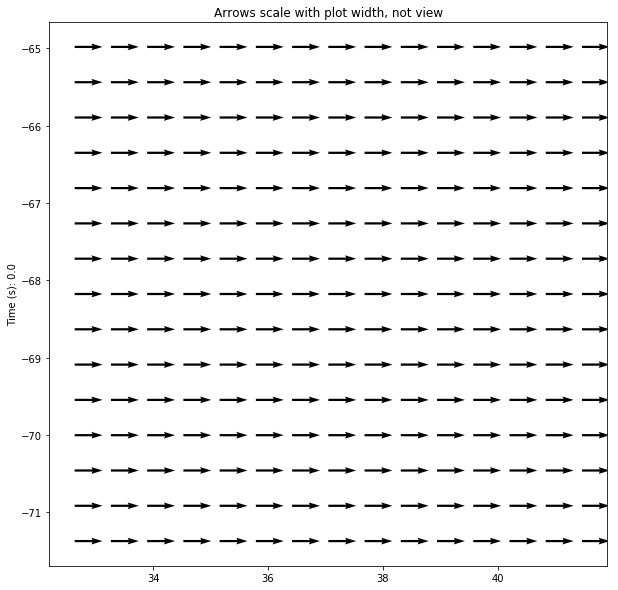

RuntimeError: Error creating movie, return code: 1 Try setting mpl.verbose.set_level("helpful")

In [10]:
import numpy as np

class timeVectorMap(object):
    """Class containing a time-varying meshgrid of U,V vectors as well as their X,Y locations"""
    class HelperFunctions(object):
        def LineTwo(self,A,B,width=(1,1),skiplast=False,Integer=False,UVFunc=lambda x,y,sT,cT : None):
            """Returns a Line between A & B with width varying from width[0] to width[1]

                TODO: Make this suck less in "Integer mode" - it's just aweful
                
                Integer ==> Returned X,Y points are integers
            """
            (x0,y0)=A
            (x1,y1)=B
            result=[]
            dx = x1 - x0
            dy = y1 - y0
            #delta=0 if width%2==0 else 1
            sqdxdy=(dx**2+dy**2)**0.5 
            #print "line length:",sqdxdy,"dx,dy:",(dx,dy)
            Xs=range(int(sqdxdy+0.5))
            if skiplast:
                Xs.pop()
            Widths=np.int32(0.5+np.linspace(width[0],width[1],len(Xs)))
            if sqdxdy>1:
                for x,thiswidth in zip(Xs,Widths):
                    for y in range(thiswidth/2,-thiswidth/2,-1):
                        result.append((x,y,None))
            sinT=dy/sqdxdy
            cosT=dx/sqdxdy
            result=[(x*cosT-y*sinT+x0,x*sinT+y*cosT+y0,UVFunc(x,y,sinT,cosT)) for x,y,w in result]
            if Integer:
                result=[(int(x+ (0.5 if x>0 else -0.5)),int(y+ (0.5 if y>0 else -0.5)),w) for x,y,w in result]
                #dedup results
                # TODO
            return result

        def Ring(self,C,R,spans=6,width=1,Integer=False,UVFunc=lambda x,y,sT,cT : None):
            """Returns a Ring centered at C of radius R with width=width made from span chords

                Integer ==> X,Y points are integers
            """
            cSteps=np.linspace(0.,2.*np.pi,spans+1)
            result=[]
            Cx,Cy=C
            for ii in cSteps[0:-1]:
                A=(Cx+R*np.cos(ii),Cy+R*np.sin(ii))
                B=(Cx+R*np.cos(ii+2.*np.pi/(spans+1)),Cy+R*np.sin(ii+2.*np.pi/(spans+1)))
                result.extend(self.LineTwo(A,B,(width,width),Integer=Integer,UVFunc=UVFunc))
            return result
        
    def __init__(self,w,h,TopLeft,BottomRight,allTimes):
        """returns an table of vectors in knots vs time"""
        self.w=w
        self.h=h
        self.TopLeft=TopLeft
        self.BottomRight=BottomRight
        self.allTimes=allTimes
        self.U,self.V,self.T=np.meshgrid(np.linspace(0.,1.,w) ,np.linspace(0.,1.,h), allTimes)
        self.X,self.Y=np.meshgrid(np.linspace(TopLeft[0], BottomRight[0],w) , \
                                  np.linspace(TopLeft[1], BottomRight[1],h))
    
    def makeFakeSinCosVectors(self,scales,windMult):
        """Create a time-varying field vectors based on sin/cos of location"""
        cnt=0
        for tim,scale in zip(self.T[0,0,:],scales):
            Uu = np.cos(self.X*scale[0]*tim*np.pi/180.)
            Vv = np.sin(self.Y*scale[1]*tim*np.pi/180.)
            Uu = Uu * abs(Uu)**2
            Vv = Vv * abs(Vv)**2
            Uu=Uu*windMult
            Vv=Vv*windMult
            self.U[...,cnt]=Uu
            self.V[...,cnt]=Vv
            cnt+=1
            
    def loads(self,filename=None,StrIn=None):
        """Get a windmap from a file on disk or a string"""
        if filename is None:
            if StrIn is None:
                raise 
                
                
        self.w=w
        self.h=h
        self.TopLeft=TopLeft
        self.BottomRight=BottomRight
        self.allTimes=allTimes
        self.U,self.V,self.T=np.meshgrid(np.linspace(0.,1.,w) ,np.linspace(0.,1.,h), [tt[0] for tt in allTimes])
        self.X,self.Y=np.meshgrid(np.linspace(TopLeft[0], BottomRight[0],w) , \
                                  np.linspace(TopLeft[1], BottomRight[1],h))
        return True

from matplotlib.animation import FuncAnimation

w,h=(30,30)
TopLeft=(41.4646,-71.3749)
BottomRight=(32.3191,-64.7526)

Steps=80
MaxTime=10.
ScaleGrowth=1.
timescales=zip(np.linspace(0.,MaxTime,Steps),np.linspace(40.,40.+ScaleGrowth,Steps))
timescales=np.linspace(0.,MaxTime,Steps)
#print timescales
#m=make_wind_map_mega(timescales=timescales)
m=timeVectorMap(w,h,TopLeft,BottomRight,timescales)
m.makeFakeSinCosVectors(zip(np.linspace(40.,40.+ScaleGrowth,Steps),np.linspace(40.,40.+ScaleGrowth,Steps)),1.)
arrowSpacing=2

fig, ax = plt.subplots(figsize=(10, 10))

#ax1=plt.subplot(211)
plt.title('Arrows scale with plot width, not view')
step=0
#cmap = plt.cm.jet
qax = ax.quiver(m.X[::arrowSpacing,::arrowSpacing], m.Y[::arrowSpacing,::arrowSpacing], \
               m.U[::arrowSpacing,::arrowSpacing,step], m.V[::arrowSpacing,::arrowSpacing,step] \
               ,units='width',scale=20)

def animate(i):
    qax.set_UVC(m.U[::arrowSpacing,::arrowSpacing,i], m.V[::arrowSpacing,::arrowSpacing,i])
    #qax.set_color(cmap(30+i*20))
    ax.set_ylabel('Time (s): ' + str(int(timescales[i]*1000)/1000.))
    
anim = FuncAnimation(
    fig, animate, interval=150, frames=len(timescales)-1)
 
plt.draw()
plt.show()

anim.save('allwinds.mp4')
#plt.figure(figsize=(10,10))
#fig, ax = plt.subplots(figsize=(10, 10))

#def make_wind_map(w=30, h=30,TopLeft=(41.4646,-71.3749),BottomRight=(32.3191,-64.7526),scale=7.,windMult=1.):
#    def __init__(self, windmap, polars,clamp_RWA=-99,H_average_speed=6,neighbor_range=2):

    

In [ ]:
w,h=(5,7)
allTimes=[(3.,1),(7.,2),(11.,5)]
U,V,T=np.meshgrid(np.linspace(0.,1.,w) ,np.linspace(0.,1.,h), [tt[0] for tt in allTimes])
X,Y=np.meshgrid(np.linspace(0.,10.,w) ,np.linspace(0.,20.,h))
print T[0,0,:]
print Y
for tim in T[0,0,:]:
            Uu = np.cos(X*tim*np.pi/180.)
            Vv = np.sin(Y*tim*np.pi/180.)
            Uu = Uu * abs(Uu)**2
            Vv = Vv * abs(Vv)**2
            Uu=Uu*windMult
            Vv=Vv*windMult
            self.U[...,cnt]=Uu
            self.V[...,cnt]=Vv

In [ ]:
foo=timeVectorMap.HelperFunctions()

In [54]:
import jsonpickle

class Thing(object):
    def __init__(self, name):
        self.name = name

obj = Thing('Awesome')
frozen = jsonpickle.encode(obj)
print frozen

{"py/object": "__main__.Thing", "name": "Awesome"}


In [ ]:
from math import floor
def sign(n):
    return (n > 0) - (n < 0)

def raytrace(A, B):
    """ Return all cells of the unit grid crossed by the line segment between
        A and B.
    """

    (xA, yA) = A
    (xB, yB) = B
    (dx, dy) = (xB - xA, yB - yA)
    (sx, sy) = (sign(dx), sign(dy))

    grid_A = (floor(A[0]), floor(A[1]))
    grid_B = (floor(B[0]), floor(B[1]))
    (x, y) = grid_A
    traversed=[grid_A]

    tIx = dy * (x + sx - xA) if dx != 0 else float("+inf")
    tIy = dx * (y + sy - yA) if dy != 0 else float("+inf")

    while (x,y) != grid_B:
        # NB if tIx == tIy we increment both x and y
        (movx, movy) = (tIx <= tIy, tIy <= tIx)

        if movx:
            # intersection is at (x + sx, yA + tIx / dx^2)
            x += sx
            tIx = dy * (x + sx - xA)

        if movy:
            # intersection is at (xA + tIy / dy^2, y + sy)
            y += sy
            tIy = dx * (y + sy - yA)

        traversed.append( (x,y) )

    return traversed

raytrace((1.,2.),(10.,10.))

In [ ]:
from math import floor
def line(A,B,width=1,span=False,skiplast=False):   #,x0), y0, x1, y1):
    "Bresenham's line algorithm"
    #TODO - pick a better way of doing this.
    (x0,y0)=A
    (x1,y1)=B
    result={}
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sqdxdy=(dx**2+dy**2)**0.5 if width>1 else 1.
    if sqdxdy<1:
        return []
    else:
        x, y = x0, y0
        sx = -1 if x0 > x1 else 1
        sy = -1 if y0 > y1 else 1
        pdy=+width/2.*dy*sy/sqdxdy
        pdx=+width/2.*dx*sx/sqdxdy
        cnt=0
        if width>1:
            near=line((floor(x0+pdy),floor(y0-pdx)),(floor(x0-pdy),floor(y0+pdx)),width=1)
            far=line((floor(x1+pdy),floor(y1-pdx)),(floor(x1-pdy),floor(y1+pdx)),width=1)
            interim=[]
            zipped=zip(near,far)
            for A1,B1 in zipped:
                interim.append(line(A1,B1,width=1))
            for point in [item for sublist in map(list, zip(*interim)) for item in sublist]:
                result[point]=cnt
                cnt+=1
        else:
            if dx > dy:
                err = dx / 2.0
                while x != x1:
                    result[(int(x), int(y))]=cnt
                    cnt+=1
                    err -= dy
                    if err < 0:
                        y += sy
                        err += dx
                    x += sx
            else:
                err = dy / 2.0
                while y != y1:
                    result[(int(x), int(y))]=cnt
                    cnt+=1
                    err -= dx
                    if err < 0:
                        x += sx
                        err += dy
                    y += sy        
            result[(int(x), int(y))]=cnt
            cnt+=1
        FinalResult=[key for key, value in sorted(result.iteritems(), key=lambda (k,v): (v,k))]
        if skiplast:
            FinalResult.pop()
        return FinalResult

#AAA=line((2,2),(20,20),skiplast=True)
#print len(AAA),AAA
#[X*Y for X,Y in AAA ]

import numpy as np
import matplotlib.pyplot as plt

foo=timeVectorMap.HelperFunctions()

Pts=[(-15,10),(15,25),(1,5)]
AAA=foo.LineTwo(*Pts,skiplast=True,Integer=True,UVFunc=lambda x,y,st,ct:(0.3*(3-abs(y))*ct,0.3*(3-abs(y))*st))
#print AAA
%matplotlib inline
fig=plt.figure(figsize=(15,15))
plt.scatter(*zip(*[(x+np.random.random()/5.,y+np.random.random()/5.) for x,y,w in AAA]),marker='x')
plt.scatter(*zip(*(Pts[0:2])),color='red')

#print AAA

BBB=foo.Ring((5,10),10,width=5,spans=15,Integer=True,UVFunc=lambda x,y,st,ct:(-0.3*(3-abs(y))*ct,-0.3*(3-abs(y))*st))
plt.scatter(*zip(*[(x+np.random.random()/5.,y+np.random.random()/5.) for x,y,w in BBB]),marker='^',color='green')

plt.quiver(*zip(*[(x,y,w[0],w[1]) for x,y,w in AAA]),scale=20,color='blue')
plt.quiver(*zip(*[(x,y,w[0],w[1]) for x,y,w in BBB]),scale=20,color='green')



In [ ]:
foo=range(5)
print foo
foo.pop()
print foo

In [ ]:
%%writefile

In [ ]:
import numpy as np
import matplotlib
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt

# Fixing random state for reproducibility
np.random.seed(19680811)


fig, ax = plt.subplots()

resolution = 50  # the number of vertices
N = 3
x = np.random.rand(N)
y = np.random.rand(N)
radii = 0.1*np.random.rand(N)
patches = []
for x1, y1, r in zip(x, y, radii):
    circle = Circle((x1, y1), r)
    patches.append(circle)

x = np.random.rand(N)
y = np.random.rand(N)
radii = 0.1*np.random.rand(N)
theta1 = 360.0*np.random.rand(N)
theta2 = 360.0*np.random.rand(N)
for x1, y1, r, t1, t2 in zip(x, y, radii, theta1, theta2):
    wedge = Wedge((x1, y1), r, t1, t2)
    patches.append(wedge)

# Some limiting conditions on Wedge
patches += [
    Wedge((.3, .7), .1, 0, 360),             # Full circle
    Wedge((.7, .8), .2, 0, 360, width=0.05),  # Full ring
    Wedge((.8, .3), .2, 0, 45),              # Full sector
    Wedge((.8, .3), .2, 45, 90, width=0.10),  # Ring sector
]

for i in range(N):
    polygon = Polygon(np.random.rand(N, 2), True)
    patches.append(polygon)

colors = 100*np.random.rand(len(patches))
p = PatchCollection(patches, alpha=0.4)
p.set_array(np.array(colors))
ax.add_collection(p)
fig.colorbar(p, ax=ax)


In [ ]:
print "ORIGINAL CODE - REV 0"
import matplotlib.pyplot as plt
import numpy as np
from numpy import ma
from myAstar import AStar
import sys
import math
%matplotlib inline


def make_wind_map(w=30, h=30,TopLeft=(41.4646,-71.3749),BottomRight=(32.3191,-64.7526),scale=7.,windMult=1.):
    """returns an table of wind vectors in knots"""
    ##TODO - make 
    result = ('+' + '='*w + '+\n') + ('|' + ' '*w + '|\n')*h + ('+' + '='*w + '+')
    Y,X = np.meshgrid(np.arange(TopLeft[0], BottomRight[0],(BottomRight[0]-TopLeft[0])/w) , \
                       np.arange(TopLeft[1], BottomRight[1],(BottomRight[1]-TopLeft[1])/h))
    U = np.cos(X*scale*np.pi/180.)
    V = np.sin(Y*scale*np.pi/180.)
    U = U * abs(U)**2
    V = V * abs(V)**2
    U=U*windMult
    V=V*windMult
    return {'text':result.strip(),'X':X,'Y':Y,'U':U,'V':V}

class PathSolver(AStar):
    """sample use of the astar algorithm. In this exemple we work on a maze made of ascii characters,
    and a 'node' is just a (x,y) tuple that represents a reachable position"""

    def __init__(self, windmap, polars,clamp_RWA=-99,H_average_speed=6,neighbor_range=2):
        self.polars_speeds = sorted(polars.keys())
        self.heuristic_average_speed=H_average_speed  #knots ==> speed used for cost estimates for unfinished
                                                      # part of the journey to the goal.
        self.polars_guts   = np.matrix([ polars[cha] for cha in self.polars_speeds])
#        self.lines = windmap['text'].strip().split('\n')
        self.width = windmap['U'].shape[0]
        self.height = windmap['U'].shape[1]
        self.windmap = windmap
        self.clamp_RWA=clamp_RWA
        #determins how far out a cell is considered a neighbor of a given cell.
        self.neigh=[(0,1),(0,-1),(-1,-1),(-1,0),(-1,1),(1,-1),(1,0),(1,1)]
        if neighbor_range>1:     #Default
            self.neigh.extend([(-2,1),(-2,-1),(-1,-2),(-1,2),(1,-2),(1,2),(2,-1),(2,1)])
        if neighbor_range>2:
            self.neigh.extend([(-3,2),(-3,1),(-3,-2),(-3,-1),(-2,-3),(-2,3),(-1,-3),(-1,3),(3,2),\
                               (3,1),(3,-2),(3,-1),(2,-3),(2,3),(1,-3),(1,3)])
        if neighbor_range>3:
            self.neigh.extend([(-4,-3),(-4,-2),(-4,-1),(-4,1),(-4,2),(-4,3),\
                               (4,-3),(4,-2),(4,-1),(4,1),(4,2),(4,3),\
                                (-3,-4),(-2,-4),(-1,-4),(1,-4),(2,-4),(3,-4),\
                               (-3,4),(-2,4),(-1,4),(1,4),(2,4),(3,4),])


    def plotPath(self, pathin, arrowSpacing=1):
        pathpoints=[(self.windmap['X'][pp[0],pp[1]],self.windmap['X'][pp[0],pp[1]],m['U'][pp[0],pp[1]],m['V'][pp[0],pp[1]]) for pp in pathin]
        plt.figure(figsize=(20,25))
        ax1=plt.subplot(211)
        
        plt.title('Arrows scale with plot width, not view')
        Q = plt.quiver(self.windmap['X'][::arrowSpacing,::arrowSpacing], self.windmap['Y'][::arrowSpacing,::arrowSpacing], \
                       self.windmap['U'][::arrowSpacing,::arrowSpacing], self.windmap['V'][::arrowSpacing,::arrowSpacing], units='width')
        qk = plt.quiverkey(Q, 0.85, 0.85, max(abs(self.windmap['U'].max()),abs(self.windmap['V'].max())), r'2 kts', labelpos='E', \
                           coordinates='figure')
        plt.plot([self.windmap['X'][pp[0],pp[1]] for pp in pathin],[self.windmap['Y'][pp[0],pp[1]] for pp in pathin],'-o')
        boatdata=[self.get_LocationParameters(pathin[ppi],pathin[ppi+1],degrees=True) for ppi in range(len(pathin)-1)]
        boatdata.append(boatdata[-1])
        ax2=plt.subplot(413,sharex=ax1)
        plt.plot([self.windmap['X'][pp[0],pp[1]] for pp in pathin],[ pp[1] for pp in boatdata],'-o',label='TWS')
        plt.plot([self.windmap['X'][pp[0],pp[1]] for pp in pathin],[ pp[5] for pp in boatdata],'-o',label='Vboat')
        plt.plot([self.windmap['X'][pp[0],pp[1]] for pp in pathin],[ pp[0] for pp in boatdata],'-o',label='dist')
        plt.legend()
        ax2=plt.subplot(414,sharex=ax1)
        plt.plot([self.windmap['X'][pp[0],pp[1]] for pp in pathin],[ pp[2] for pp in boatdata],'-x',label='TWA')
        plt.plot([self.windmap['X'][pp[0],pp[1]] for pp in pathin],[ pp[3] for pp in boatdata],'-x',label='RWA')
        plt.plot([self.windmap['X'][pp[0],pp[1]] for pp in pathin],[ pp[4] for pp in boatdata],'-x',label='Co')
        plt.legend()
        return boatdata
        
    def unit_vector(self,vector):
        """ Returns the unit vector of the vector.  """
        return vector / np.linalg.norm(vector)

    def angle_between(self,v1, v2):
        """ Returns the angle in radians between vectors 'v1' and 'v2'::

                >>> angle_between((1, 0, 0), (0, 1, 0))
                1.5707963267948966
                >>> angle_between((1, 0, 0), (1, 0, 0))
                0.0
                >>> angle_between((1, 0, 0), (-1, 0, 0))
                3.141592653589793
        """
        v1_u = self.unit_vector(v1)
        v2_u = self.unit_vector(v2)
        return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

    def speed_from_polars(self,RWA,TWS=6):
        if self.clamp_RWA>0 and RWA<self.clamp_RWA:
            result=-99
        else:
            order=self.polars_guts.shape[1]
            y=np.ones(order)
            for i in range(order-1,0,-1):
                y[i-1]=y[i]*RWA
            result_vec=(self.polars_guts*np.matrix(y).transpose()).transpose().tolist()
            result=np.interp(TWS,[0.] + self.polars_speeds + [self.polars_speeds[-1]*3], \
                             [0.] + result_vec[0] + [result_vec[0][-1]],left=-99,right=-99)
        if result > 0:
            return result
        else:
            return 0.001

    def get_LocationParameters(self,n1,n2, gscore=0,degrees=False):

        #TODO ==> adjust wind speed based on gscore (time)
        #TODO ==> add Current lookup and speed
        (x1, y1) = n1
        (x2, y2) = n2
        (La1,Lo1) = (self.windmap['Y'][x1,y1],self.windmap['X'][x1,y1])
        (La2,Lo2) = (self.windmap['Y'][x2,y2],self.windmap['X'][x2,y2])
        wind=(-self.windmap['U'][x1,y1],-self.windmap['V'][x1,y1])
        boat_vector=(x2-x1,y1-y2)
        meanLat=(La1+La2)/2.
        TWS=math.hypot(wind[0],wind[1])
        #distance in nm
        dist=math.hypot((Lo2 - Lo1)*np.cos(meanLat*np.pi/180.), La2 - La1)*60.
        #print "Wind:",wind, " TWA:",(np.arctan2(wind[0],wind[1])*180./np.pi+360)%360
        #print "boat_vector:", boat_vector, " Boat Course:",
        if degrees:
            TWA=(np.arctan2(wind[0],wind[1])*180./np.pi+360)%360
            course=(np.arctan2(boat_vector[0],boat_vector[1])*180./np.pi+360)%360
        else:
            TWA=np.arctan2(wind[0],wind[1])
            course=np.arctan2(boat_vector[0],boat_vector[1])
        #print "boat_vector:", boat_vector, " Boat Course:",
        RWA=self.angle_between(wind,boat_vector)
        #print "Relative True Wind Angle:",ang*180/np.pi
        BoatSpeed=self.speed_from_polars(RWA,TWS)
        #print "Boat Speed: ", BoatSpeed
        if degrees:
            RWA=RWA*180/np.pi
        return dist,TWS,TWA,RWA,course,BoatSpeed
    
#### Below are the standard A-Star Functions
    def heuristic_cost_estimate(self, n1, n2, gscore=0):
        """computes the time to travel 'direct' distance between two (x,y) tuples"""
        #TODO ==> use smarter heuristic based on 
        (x1, y1) = n1
        (x2, y2) = n2
        (La1,Lo1) = (self.windmap['Y'][x1,y1],self.windmap['X'][x1,y1])
        (La2,Lo2) = (self.windmap['Y'][x2,y2],self.windmap['X'][x2,y2])
        meanLat=(La1+La2)/2.
        dist=math.hypot((Lo2 - Lo1)*np.cos(meanLat*np.pi/180.), La2 - La1)*60./self.heuristic_average_speed
        return dist

    def distance_between(self, n1, n2, gscore=0):
        """this method returns the time to travel into a neighbor's cell based on conditions in the current cell"""
        # We're cheating a bit as some of the neighbors aren't exactly adjacent but we're 
        # assuming the prevailing local conditions are such that it doesn't matter 
        dist,TWS,TWA,RWA,course,BoatSpeed = self.get_LocationParameters(n1,n2,gscore)
        #cost is distance/speed
        return dist / BoatSpeed

    def neighbors(self, node):
        """ for a given coordinate in the maze, returns up to adjacent
            nodes that can be reached 
        """
        x, y = node
        return[(nx, ny) for nx, ny in [(x+xx,y+yy) for xx,yy in self.neigh] if 0 <= nx < self.width and \
               0 <= ny < self.height ]

size = 200
# what is the size of it?
w = 160
h = 280
m = make_wind_map(w,h,scale=35,windMult=20.)

# table of 8th order Polinomials representing boat speed vs TWA
# 1st term is X^8 last term is X^0
#

Lowest_RelativeWindAngle=38. 

PS=PathSolver(m,mypolars,Lowest_RelativeWindAngle*np.pi/180,neighbor_range=3)

start = (2, 2)  # we choose to start at the upper left corner
goal = (h - 3,w - 3)  # we want to reach the lower right corner

# let's solve it
foundPath = list(PS.astar(start, goal))
# print the solution
pPPS=PS.plotPath(foundPath,arrowSpacing=5)
#print pPPS